In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from omegaconf import OmegaConf
from models.flow_module import FlowModule
import torch
from data.pdb_dataloader import PdbDataModule
import glob
import GPUtil
from data import utils as du
from scipy.spatial.transform import Rotation
import numpy as np
import tree
from data import so3_utils
from data import all_atom
from analysis import plotting
from analysis import utils as au
from openfold.utils.superimposition import superimpose
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
# Setup lightning module

# ckpt_dir = 'ckpt/se3-fm/warm_start_baseline/2023-09-04_15-13-01'
# ckpt_dir = 'ckpt/se3-fm/flower/2023-09-04_20-54-39/'
# ckpt_dir = 'ckpt/se3-fm/warm_start/2023-08-30_17-36-07'
ckpt_dir = '/data/rsg/chemistry/jyim/projects/flow-matching/ckpt/se3-fm/warm_start/2023-09-05_20-21-01'
ckpt_path = sorted(glob.glob(os.path.join(ckpt_dir, '*.ckpt')))[-1]
print(ckpt_path)

cfg_path = os.path.join(ckpt_dir, 'config.yaml')
ckpt_cfg = OmegaConf.load(cfg_path)
base_path = 'configs/base.yaml'
base_cfg = OmegaConf.load(base_path)

OmegaConf.set_struct(base_cfg, False)
OmegaConf.set_struct(ckpt_cfg, False)
cfg = OmegaConf.merge(base_cfg, ckpt_cfg)
cfg.experiment.checkpointer.dirpath = './'

flow = FlowModule.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    model_cfg=cfg.model,
    experiment_cfg=cfg.experiment
) 
_ = flow.eval()

/data/rsg/chemistry/jyim/projects/flow-matching/ckpt/se3-fm/warm_start/2023-09-05_20-21-01/last.ckpt


In [5]:
# Set up data module
data_module = PdbDataModule(cfg.data)
data_module.setup('fit')
train_dataloader = data_module.train_dataloader(
    num_replicas=1,
    rank=1
)
data_iter = iter(train_dataloader)


In [6]:
# Search for a reasonable batch
stop_search = False
while not stop_search: 
    batch = next(data_iter)
    num_batch, num_res, _ = batch['trans_1'].shape
    if num_res > 70 and num_res < 100:
        stop_search = True

print(f'Found batch with {num_res} residues, {num_batch} batch size')

# Set up device and cuda
num_batch, num_res, _ = batch['trans_1'].shape
# cuda_id = GPUtil.getAvailable(order='memory', limit = 8)[0]
# device = f'cuda:{cuda_id}'
device = 'cuda:0'
# device = 'cpu'
print(f'Using device {device}')
flow.model = flow.model.to(device)
batch = tree.map_structure(lambda x: x.to(device), batch)
num_batch = batch['res_mask'].shape[0]

print(batch['trans_1'].shape)
print(batch['rotmats_1'].shape)

Found batch with 75 residues, 90 batch size
Using device cuda:0
torch.Size([90, 75, 3])
torch.Size([90, 75, 3, 3])


In [6]:
batch.keys()

dict_keys(['aatype', 'res_idx', 'rotmats_1', 'trans_1', 'res_mask', 'csv_idx'])

In [7]:
batch['res_idx']

tensor([[ 1,  2,  3,  ..., 73, 74, 75],
        [ 1,  2,  3,  ..., 73, 74, 75],
        [ 1,  2,  3,  ..., 73, 74, 75],
        ...,
        [ 1,  2,  3,  ..., 73, 74, 75],
        [ 1,  2,  3,  ..., 73, 74, 75],
        [ 1,  2,  3,  ..., 73, 74, 75]], device='cuda:0')

In [49]:
for key in batch.keys():
    print(batch[key].shape)

torch.Size([90, 75])
torch.Size([90, 75])
torch.Size([90, 75, 3, 3])
torch.Size([90, 75, 3])
torch.Size([90, 75])
torch.Size([90, 1])
torch.Size([90, 75, 3])
torch.Size([90, 75, 3, 3])
torch.Size([90, 1])


# Utils

In [7]:
def atom37_from_trans_rot(trans, rots, res_mask):
        rigids = du.create_rigid(rots, trans)
        atom37 = all_atom.compute_backbone(
            rigids,
            torch.zeros(
                trans.shape[0],
                trans.shape[1],
                2,
                device=trans.device
            )
        )[0]
        atom37 = atom37.detach().cpu()
        batch_atom37 = []
        for i in range(num_batch):
            batch_atom37.append(
                du.adjust_oxygen_pos(atom37[i], res_mask[i])
            )
        return torch.stack(batch_atom37)

def process_trans_rot_traj(trans_traj, rots_traj, res_mask):
    res_mask = res_mask.detach().cpu()
    atom37_traj = [
         atom37_from_trans_rot(trans, rots, res_mask)
         for trans, rots in zip(trans_traj, rots_traj) 
    ]
    atom37_traj = torch.stack(atom37_traj).swapaxes(0, 1)
    return atom37_traj 

def new_batch_size(n, batch):
    return {key: batch[key][0:n, ...] for key in batch.keys()}

# SDE and ODE sampling

In [40]:
small_batch = new_batch_size(5, batch)
sampling_outputs = flow.run_sampling([small_batch, None], return_traj=True,
                                     return_model_outputs=False, num_timesteps=100,
                                     do_sde=True)
prot_traj = sampling_outputs
print(type(prot_traj))

<class 'list'>


In [7]:
# ODE

return_traj = False

res_mask = batch['res_mask']
device = res_mask.device
print("sampling with device", device)
num_batch, num_res = res_mask.shape[:2]
trans_0 = flow._centered_gaussian(
    (num_batch, num_res, 3), device) * du.NM_TO_ANG_SCALE
rots_0 = torch.tensor(
    Rotation.random(num_batch*num_res).as_matrix(),
    device=device,
    dtype=torch.float32,
).view(num_batch, num_res, 3, 3)
print("rots_0", rots_0.shape)
if rots_0.ndim == 3:
    rots_0 = rots_0[None]

prot_traj = [(trans_0, rots_0)]
num_timesteps = flow._sampling_cfg.num_timesteps
ts = np.linspace(flow._sampling_cfg.min_t, 1.0, num_timesteps)
t_1 = ts[0]
model_traj = []
for t_2 in tqdm(ts[1:]):
    d_t = t_2 - t_1
    trans_t_1, rots_t_1 = prot_traj[-1]
    with torch.no_grad():
        if flow._exp_cfg.noise_trans:
            batch['trans_t'] = trans_t_1
        else:
            batch['trans_t'] = batch['trans_1']
        if flow._exp_cfg.noise_rots:
            batch['rotmats_t'] = rots_t_1
        else:
            batch['rotmats_t'] = batch['rotmats_1']
        batch['t'] = torch.ones((num_batch, 1)).to(device) * t_1
        model_out = flow.forward(batch)

    pred_trans_1 = model_out['pred_trans']
    pred_rots_1 = model_out['pred_rotmats']
    pred_rots_vf = model_out['pred_rots_vf']

    model_traj.append(
        (pred_trans_1.detach().cpu(), pred_rots_1.detach().cpu())
    )

    trans_vf = (pred_trans_1 - trans_t_1) / (1 - t_1)
    trans_t_2 = trans_t_1 + trans_vf * d_t
    if flow._model_cfg.predict_rot_vf:
        rots_t_2 = so3_utils.geodesic_t(
            d_t / (1 - t_1), pred_rots_1, rots_t_1, rot_vf=pred_rots_vf)
    else:
        rots_t_2 = so3_utils.geodesic_t(
            d_t / (1 - t_1), pred_rots_1, rots_t_1) 
    t_1 = t_2
    if return_traj:
        prot_traj.append((trans_t_2, rots_t_2))
    else:
        prot_traj[-1] = (trans_t_2, rots_t_2)

atom37_traj = all_atom.transrot_to_atom37(prot_traj, res_mask)
atom37_traj = atom37_traj[0]

sampling with device cuda:0
rots_0 torch.Size([90, 75, 3, 3])


  0%|          | 0/99 [00:00<?, ?it/s]/Mounts/rbg-storage1/users/campbell/mamba/envs/fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 99/99 [00:22<00:00,  4.45it/s]


In [16]:
# SDE

return_traj = True


batch = new_batch_size(5, batch)
res_mask = batch['res_mask']
device = res_mask.device
print("sampling with device", device)
num_batch, num_res = res_mask.shape[:2]
trans_0 = flow._centered_gaussian(
    (num_batch, num_res, 3), device) * du.NM_TO_ANG_SCALE
rots_0 = torch.tensor(
    Rotation.random(num_batch*num_res).as_matrix(),
    device=device,
    dtype=torch.float32,
).view(num_batch, num_res, 3, 3)
print("rots_0", rots_0.shape)
if rots_0.ndim == 3:
    rots_0 = rots_0[None]

prot_traj = [(trans_0, rots_0)]
# num_timesteps = flow._sampling_cfg.num_timesteps
num_timesteps = 1000
ts = np.linspace(1.0 - flow._sampling_cfg.min_t, flow._sampling_cfg.min_t, num_timesteps)
t_1 = ts[0]
model_traj = []
for t_2 in tqdm(ts[1:]):
    d_t = t_2 - t_1
    trans_t_1, rots_t_1 = prot_traj[-1]
    with torch.no_grad():
        if flow._exp_cfg.noise_trans:
            batch['trans_t'] = trans_t_1
        else:
            batch['trans_t'] = batch['trans_1']
        if flow._exp_cfg.noise_rots:
            batch['rotmats_t'] = rots_t_1
        else:
            batch['rotmats_t'] = batch['rotmats_1']
        batch['t'] = torch.ones((num_batch, 1)).to(device) * (1 - t_1)
        model_out = flow.forward(batch)

    pred_trans_1 = model_out['pred_trans']
    pred_rots_1 = model_out['pred_rotmats']
    pred_rots_vf = model_out['pred_rots_vf']

    model_traj.append(
        (pred_trans_1.detach().cpu(), pred_rots_1.detach().cpu())
    )
    assert d_t < 0

    # sde
    trans_score = ((1 - t_1) * pred_trans_1 - trans_t_1) / (t_1**2 * du.NM_TO_ANG_SCALE**2)
    trans_t_2 = (((-1)/(1-t_1)) * trans_t_1 - du.NM_TO_ANG_SCALE**2 * ((2 * t_1) / (1 - t_1)) * trans_score) * d_t + trans_t_1
    trans_t_2 = trans_t_2 + torch.randn_like(trans_t_2) * np.sqrt( (-d_t) * (2 * t_1) / (1 - t_1)  ) * du.NM_TO_ANG_SCALE

    # ode
    # trans_t_2 = trans_t_1 + ((pred_trans_1 - trans_t_1) / t_1) * (- d_t)

    assert not flow._model_cfg.predict_rot_vf

    # ODE for the rotations
    rots_t_2 = so3_utils.geodesic_t(
        (-d_t) / t_1, pred_rots_1, rots_t_1) 

    t_1 = t_2
    if return_traj:
        prot_traj.append((trans_t_2, rots_t_2))
    else:
        prot_traj[-1] = (trans_t_2, rots_t_2)

# final prediction
t_1 = ts[-1]
trans_t_1, rots_t_1 = prot_traj[-1]
with torch.no_grad():
    if flow._exp_cfg.noise_trans:
        batch['trans_t'] = trans_t_1
    else:
        batch['trans_t'] = batch['trans_1']
    if flow._exp_cfg.noise_rots:
        batch['rotmats_t'] = rots_t_1
    else:
        batch['rotmats_t'] = batch['rotmats_1']
    batch['t'] = torch.ones((num_batch, 1)).to(device) * (1 - t_1)
    model_out = flow.forward(batch)

pred_trans_1 = model_out['pred_trans']
pred_rots_1 = model_out['pred_rotmats']
pred_rots_vf = model_out['pred_rots_vf']

trans_t_2 = pred_trans_1
rots_t_2 = pred_rots_1

model_traj.append(
    (pred_trans_1.detach().cpu(), pred_rots_1.detach().cpu())
)

if return_traj:
    prot_traj.append((trans_t_2, rots_t_2))
else:
    prot_traj[-1] = (trans_t_2, rots_t_2)




atom37_traj = all_atom.transrot_to_atom37(prot_traj, res_mask)
atom37_traj = atom37_traj[-1]

sampling with device cuda:0
rots_0 torch.Size([5, 75, 3, 3])


  0%|          | 0/999 [00:00<?, ?it/s]/Mounts/rbg-storage1/users/campbell/mamba/envs/fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 999/999 [00:28<00:00, 34.90it/s]


In [80]:
# Save x0 predictions
b_idx = 0
import shutil
save_dir = 'notebook_samples/'
shutil.rmtree(save_dir)
os.makedirs(save_dir, exist_ok=True)
model_atom37_traj = all_atom.transrot_to_atom37(model_traj, res_mask)
model_atom37_traj_np = np.array([du.to_numpy(x) for x in model_atom37_traj])

_, num_batch, num_res, _, _ = model_atom37_traj_np.shape

save_bits = np.linspace(0, model_atom37_traj_np.shape[0]-1, 10, dtype=int)

for save_bit in save_bits:
    sample_path = au.write_prot_to_pdb(
        model_atom37_traj_np[save_bit, 0, ...],
        os.path.join(
            save_dir,
            f'x0_sample_{b_idx}_len_{num_res}_tidx_{save_bit}.pdb'),
        no_indexing=True
    )

In [21]:
# Save xt progression
b_idx = 0
import shutil
save_dir = 'notebook_samples/'
shutil.rmtree(save_dir)
os.makedirs(save_dir, exist_ok=True)
prot_atom37_traj = all_atom.transrot_to_atom37(prot_traj, res_mask)
prot_atom37_traj_np = np.array([du.to_numpy(x) for x in prot_atom37_traj])
print("prot_atom37_traj_np", prot_atom37_traj_np.shape)

_, num_batch, num_res, _, _ = prot_atom37_traj_np.shape

save_bits = np.linspace(0, prot_atom37_traj_np.shape[0]-1, 10, dtype=int)

for save_bit in save_bits:
    sample_path = au.write_prot_to_pdb(
        prot_atom37_traj_np[save_bit, 0, ...],
        os.path.join(
            save_dir,
            f'xt_sample_{b_idx}_len_{num_res}_tidx_{save_bit}.pdb'),
        no_indexing=True
    )

prot_atom37_traj_np (1000, 5, 75, 37, 3)


In [28]:
# Save final samples
import shutil
save_dir = 'notebook_samples/'
shutil.rmtree(save_dir)
os.makedirs(save_dir, exist_ok=True)

atom37_traj_np = du.to_numpy(atom37_traj)
print("atom37_traj_np shape", atom37_traj_np.shape)
num_batch, num_res, _, _ = atom37_traj_np.shape


max_save = 5
for i, sample_traj in enumerate(atom37_traj_np):
    if i >= max_save:
        break
    sample_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}.pdb'),
        no_indexing=True
    )

atom37_traj_np shape (5, 75, 37, 3)


prot_traj_trans_np (101, 75, 37, 3)


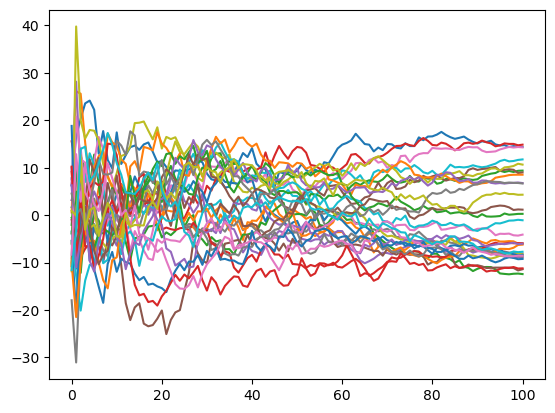

In [41]:
# plot some progression of positions
prot_traj_trans_np = np.array([x[0].cpu().detach().numpy() for x in prot_traj])
print("prot_traj_trans_np", prot_traj_trans_np.shape)
for i in range(prot_traj_trans_np.shape[0]):
    prot_traj_trans_np[i] = prot_traj_trans_np[i] - np.mean(prot_traj_trans_np[i], axis=1, keepdims=True)
for i in range(10):
    plt.plot(prot_traj_trans_np[:, i, 1, :])
# plt.xlim([-1, 10])
plt.show()

# Model prediction at different timesteps

In [7]:
gt_ca_pos = batch['trans_1']
device = gt_ca_pos.device
num_batch = gt_ca_pos.shape[0]
ts = np.linspace(1e-3, 1.0, 100)
all_pred_ca = []
for i,t in enumerate(ts):
    print(f'On {i}')
    batch_t = torch.ones(num_batch, 1, 1, device=device) * t
    noisy_batch = flow._corrupt_batch(batch, t=batch_t)
    with torch.no_grad():
        model_out = flow.forward(noisy_batch)
    all_pred_ca.append(du.to_numpy(model_out['pred_trans']))
all_pred_ca = np.stack(all_pred_ca)

On 0


/data/rsg/chemistry/campbell/flow-matching/data/utils.py:329: UserWarning: Specified kernel cache directory is not writable! This disables kernel caching. Specified directory is /afs/csail.mit.edu/u/c/campbell/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cuda/jit_utils.cpp:1460.)
  sign_correction = torch.sign(torch.linalg.det(torch.bmm(v, u_t)))
/Mounts/rbg-storage1/users/campbell/mamba/envs/fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


On 1
On 2
On 3
On 4
On 5
On 6
On 7
On 8
On 9
On 10
On 11
On 12
On 13
On 14
On 15
On 16
On 17
On 18
On 19
On 20
On 21
On 22
On 23
On 24
On 25
On 26
On 27
On 28
On 29
On 30
On 31
On 32
On 33
On 34
On 35
On 36
On 37
On 38
On 39
On 40
On 41
On 42
On 43
On 44
On 45
On 46
On 47
On 48
On 49
On 50
On 51
On 52
On 53
On 54
On 55
On 56
On 57
On 58
On 59
On 60
On 61
On 62
On 63
On 64
On 65
On 66
On 67
On 68
On 69
On 70
On 71
On 72
On 73
On 74
On 75
On 76
On 77
On 78
On 79
On 80
On 81
On 82
On 83
On 84
On 85
On 86
On 87
On 88
On 89
On 90
On 91
On 92
On 93
On 94
On 95
On 96
On 97
On 98
On 99


In [8]:
res_mask = batch['res_mask']
aligned_sample_ca, aligned_rmsd = superimpose(
    torch.tensor(gt_ca_pos)[None].repeat(100, 1, 1, 1),
    torch.tensor(all_pred_ca).to(gt_ca_pos.device),
    res_mask[None].repeat(100, 1, 1)
)
torch.mean(aligned_rmsd)

/tmp/ipykernel_149982/870693686.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(gt_ca_pos)[None].repeat(100, 1, 1, 1),


tensor(2.3538, device='cuda:1')

In [9]:
ts_rmsd = du.to_numpy(torch.mean(aligned_rmsd, dim=-1))

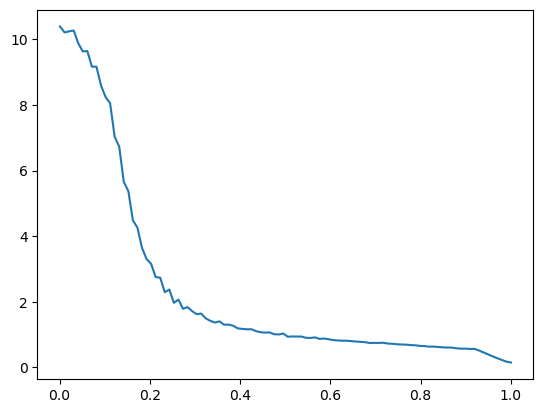

In [10]:
plt.plot(ts, ts_rmsd)
# plt.plot(ts, noisy_rmsds)

# Partial sampling

In [11]:
min_t = 1e-3
t = torch.ones(num_batch, 1, 1, device=device) * min_t
noisy_batch = flow._corrupt_batch(batch, t=t)
batch_trunc = 5
trans_in = du.to_numpy(noisy_batch['trans_t'][:batch_trunc])
gt = du.to_numpy(noisy_batch['trans_1'][:batch_trunc])


In [12]:
# Run sampling
trans_traj = [noisy_batch['trans_t']]
rots_traj = [noisy_batch['rotmats_t']]
num_timesteps = 100
ts = np.linspace(min_t, 1.0, num_timesteps)
t_1 = ts[0]
model_outputs = []
trans_vf_traj = []
for i,t_2 in enumerate(ts[1:]):
    if (i+1) % 100 == 0:
        print(f"Step {i+1} / {len(ts)}")
    d_t = t_2 - t_1
    trans_t_1 = trans_traj[-1]
    rots_t_1 = rots_traj[-1]
    with torch.no_grad():
        batch['trans_t'] = trans_t_1
        batch['rotmats_t'] = rots_t_1
        batch['t'] = torch.ones((num_batch, 1)).to(device) * t_1
        model_out = flow.forward(batch)
        model_outputs.append(
            tree.map_structure(lambda x: du.to_numpy(x), model_out)
        )

    pred_trans_1 = model_out['pred_trans']
    pred_rots_1 = model_out['pred_rotmats']
    pred_rots_vf = model_out['pred_rots_vf']

    trans_vf = (pred_trans_1 - trans_t_1) / (1 - t_1)
    trans_t_2 = trans_t_1 + trans_vf * d_t
    rots_t_2 = so3_utils.geodesic_t(
        d_t / (1 - t_1), pred_rots_1, rots_t_1, rot_vf=pred_rots_vf)
    t_1 = t_2
    trans_traj.append(trans_t_2)
    rots_traj.append(rots_t_2)

res_mask = batch['res_mask']
atom37_traj = process_trans_rot_traj(trans_traj, rots_traj, res_mask)
final_ca_pos = atom37_traj[:, -1, :, 1]
gt_ca_pos = batch['trans_1']

In [13]:
aligned_sample_ca, aligned_rmsd = superimpose(
    gt_ca_pos,
    final_ca_pos.to(gt_ca_pos.device),
    res_mask
)
torch.mean(aligned_rmsd)

tensor(12.1245, device='cuda:1')

In [15]:
# Save samples
save_dir = 'notebook_samples/'
os.makedirs(save_dir, exist_ok=True)
atom37_traj = du.to_numpy(atom37_traj)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    # traj_path = au.write_prot_to_pdb(
    #     sample_traj,
    #     os.path.join(
    #         save_dir,
    #         f'traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
    #     no_indexing=True
    # )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    print(f'Done with sample {i}')

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
gt_trans_1 = batch['trans_1']
gt_rotmats_1 = batch['rotmats_1']

gt_atom37 = atom37_from_trans_rot(
    gt_trans_1.detach().cpu(),
    gt_rotmats_1.detach().cpu(),
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)

In [ ]:
for i, gt_coords in enumerate(gt_atom37):
    if i >= max_save:
        break
    sample_path = au.write_prot_to_pdb(
        gt_coords,
        os.path.join(
            save_dir,
            f'gt_{i}_len_{num_res}.pdb'),
        no_indexing=True
    )
    print(f'Done with sample {i}')

## Calculate SNR

In [ ]:
gt_ca_pos = batch['trans_1']
device = gt_ca_pos.device
num_batch = gt_ca_pos.shape[0]
all_noise = {}
for i,t in enumerate(ts):
    print(f'On {i}')
    noisy_ca_pos = []
    batch_t = torch.ones(num_batch, 1, 1, device=device) * t 
    for _ in range(10):
        noisy_batch = flow._corrupt_batch(batch, t=batch_t)
        noisy_ca_pos.append(noisy_batch['trans_t'])
    noisy_ca_pos = torch.stack(noisy_ca_pos)
    all_noise[i] = noisy_ca_pos

In [ ]:
def calc_rmsd(x, y):
    return torch.mean(torch.linalg.norm(x - y, dim=-1))

In [ ]:
noisy_rmsds = []
for i in range(len(all_noise)):
    noisy_ca_pos = all_noise[i]
    rmsd = calc_rmsd(noisy_ca_pos, gt_ca_pos[None])
    noisy_rmsds.append(rmsd)
noisy_rmsds = du.to_numpy(torch.stack(noisy_rmsds))

In [ ]:
plt.plot(ts, noisy_rmsds)

## Process and save samples

In [ ]:
save_dir = 'notebook_samples/'
os.makedirs(save_dir, exist_ok=True)
atom37_traj = du.to_numpy(atom37_traj)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    traj_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    print(f'Done with sample {i}')

## Visualize structures

In [ ]:
idx = 0
model_out_ca = model_outputs[-1]['pred_trans'][idx]
sample_bb_3d = plotting.create_scatter(model_out_ca, mode='lines+markers', marker_size=3, opacity=1.0)
plotting.plot_traces([sample_bb_3d])

In [ ]:
idx = 0
t_idx = -1
model_out_ca = model_outputs[t_idx]['pred_trans'][idx]
model_in_ca = trans_in[idx]
gt_ca = gt[idx]

out_bb_3d = plotting.create_scatter(
    model_out_ca, mode='lines+markers', marker_size=3, opacity=1.0, name='pred')
in_bb_3d = plotting.create_scatter(
    model_in_ca, mode='lines+markers', marker_size=3, opacity=1.0, name=f'input t={ts[t_idx]:.2f}')
gt_bb_3d = plotting.create_scatter(
    gt_ca, mode='lines+markers', marker_size=3, opacity=1.0, name='gt')
plotting.plot_traces([
    out_bb_3d,
    # in_bb_3d,
    gt_bb_3d
])
